In [2]:
import numpy as np
from scipy.stats import norm
import yaml
import func_definitions as fd
from numpy.random import default_rng
from concurrent.futures import ThreadPoolExecutor
import threading
import pandas as pd
import matplotlib.pyplot as plt

def load_config(path="config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [ ]:
config = load_config()
sim = config["simulation"]
    
rng = default_rng(sim["seed"])
seed = sim["seed"]
print(f"Seed, {seed}")

# Initialize CEM parameters
CEM_param = sim["CEM"]
N = CEM_param["N"]
print(f"N, {N}")
alpha = CEM_param["alpha"]
print(f"alpha, {alpha}")
elite = CEM_param["elite"]
print(f"elite, {elite}")

# Distortion and risk measure parameters
h = sim["h"]
option_h = h["option_h"]
print("option_h", option_h)
param_h = h["param_h"]
print("param_h", param_h)
d = sim["d"]
option_d = d["name"]
print("option_d", option_d)

# Simulation parameters
tmax = sim["tmax"]
print("tmax", tmax)

Seed, 42
N, 20
alpha, 0.3
elite, 5
option_h Power
param_h 0.1
option_d SE
tmax 10


[27.48752  29.00543  29.400507 ... 23.029476 22.867918 22.740608]
threshold 28.09


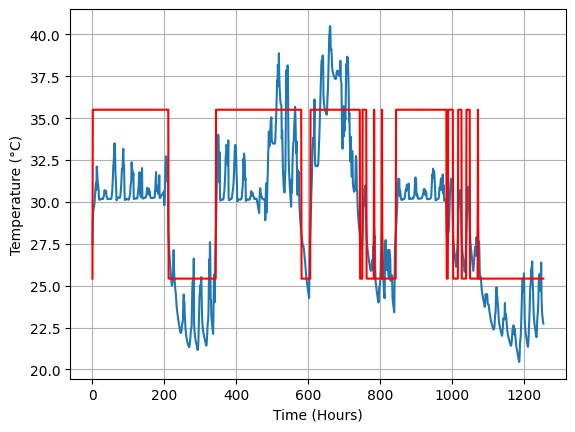

28.928089798566877 4.245498192965265
f_min: 37.0162590548294


In [ ]:
df = pd.read_excel('Twin_house_exp2_60min.xlsx')

Xd = df.iloc[1:, 8]
Xtemp = pd.to_numeric(Xd, errors='coerce') 
X2 = Xtemp.to_numpy()
X = X2[~np.isnan(X2)]
s = np.size(X)
print(X)

threshold = (24.44 + 31.74)/2
x = 25.42309536
y = 35.50534689
print("threshold", threshold)
v_quantized = np.where(X >= threshold, y, x)

plt.plot(X)
plt.plot(v_quantized, color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

mean = np.mean(X)
std = np.std(X)
print(mean, std)

# Initialize search and optimal solution
mu = np.zeros(2)
mu[0] = mean-std
mu[1] = mean+std
sig = np.zeros(2)
sig[0] = std
sig[1] = std
opt_sol = np.zeros(2)
opt_sol[0] = mu[0]
opt_sol[1] = mu[1]

# Initial fmin
f_min = fd.risk_measure(mu,X,option_d=option_d,param_d=None,option_h=option_h,param_h=param_h)
print(f"f_min: {f_min}")

In [ ]:
t = 0
while t <= tmax:
    t += 1 
    print(t)
    samples = np.column_stack([
        norm.rvs(loc=mu[0], scale=sig[0], size=N),
        norm.rvs(loc=mu[1], scale=sig[1], size=N)
    ])

    with ThreadPoolExecutor() as executor:
        f_eval = list(executor.map(lambda sample: fd.risk_measure(sample, X, option_d=option_d,param_d=None,option_h=option_h,param_h=param_h), samples))

    f_eval = np.array(f_eval)

    good_indices = np.where(f_eval < f_min)[0]

    better_indices = np.where(f_eval < f_min)[0]
    if better_indices.size > 0:
        best_idx = better_indices[np.argmin(f_eval[better_indices])]
        opt_sol[:] = samples[best_idx]
        f_min = f_eval[best_idx]
    
    print("opt solution so far", opt_sol)
    print("f_min", f_min)
    

    if good_indices.size > 0:
        elite_indices = good_indices[np.argsort(f_eval[good_indices])[:elite]]
        elite_samples = samples[elite_indices]
    else:
        elite_samples[:] = opt_sol  # Handle empty case

    mu_update = np.mean(elite_samples, axis=0)
    sig_update2 = np.mean((elite_samples - mu_update) ** 2, axis=0)

    #  Smoothing
    mu[:] = (1 - alpha) * mu + alpha * mu_update
    sig[:] = (1 - alpha) * sig + alpha * np.sqrt(sig_update2)

    print("current mu")
    print(mu)
    print("current sig")
    print(sig)

1
opt solution so far [25.49090151 36.62093626]
f_min 27.713211224905415
current mu
[24.756898   34.25867661]
current sig
[3.08518595 3.0702116 ]
2
opt solution so far [25.49090151 36.62093626]
f_min 27.713211224905415
current mu
[24.97709905 34.9673545 ]
current sig
[2.15963016 2.14914812]
3
opt solution so far [24.05387248 34.79682699]
f_min 26.791724509360048
current mu
[24.9371434  35.20146521]
current sig
[1.74875343 1.78967265]
4
opt solution so far [25.6673273  35.67272355]
f_min 23.935078949263154
current mu
[25.00211223 35.36407678]
current sig
[1.39871644 1.39263361]
5
opt solution so far [25.6673273  35.67272355]
f_min 23.935078949263154
current mu
[25.20167675 35.45667081]
current sig
[0.97910151 0.97484352]
6
opt solution so far [25.6673273  35.67272355]
f_min 23.935078949263154
current mu
[25.34137192 35.52148663]
current sig
[0.68537106 0.68239047]
7
opt solution so far [25.6673273  35.67272355]
f_min 23.935078949263154
current mu
[25.43915853 35.56685771]
current sig
[0

In [19]:
print("Optimal Solution", opt_sol)
print("f_min", f_min)
print("Risk alpha = 1", fd.risk_measure(opt_sol,X,option_d=option_d,param_d=None,option_h=option_h,param_h=1))
print("Risk alpha = 0.5", fd.risk_measure(opt_sol,X,option_d=option_d,param_d=None,option_h=option_h,param_h=0.5))
print("Risk alpha = 0.1", fd.risk_measure(opt_sol,X,option_d=option_d,param_d=None,option_h=option_h,param_h=0.1))

Optimal Solution [25.42309536 35.50534689]
f_min 23.154162752932827
Risk alpha = 1 12.139118332423184
Risk alpha = 0.5 16.884792103392858
Risk alpha = 0.1 23.154162752932827
